In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("dineshmanikanta/machine-failure-predictions")

print("Path to dataset files:", path)

In [21]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, Ridge, SGDRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from xgboost import XGBClassifier, XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [1]:


df = pd.read_csv("/kaggle/input/machine-failure-predictions/machine failure.csv")
print(df.head()) # overview: 14 fields(columns)

   UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
0    1     M14860    M                298.1                    308.6   
1    2     L47181    L                298.2                    308.7   
2    3     L47182    L                298.1                    308.5   
3    4     L47183    L                298.2                    308.6   
4    5     L47184    L                298.2                    308.7   

   Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Machine failure  TWF  \
0                    1551         42.8                0                0    0   
1                    1408         46.3                3                0    0   
2                    1498         49.4                5                0    0   
3                    1433         39.5                7                0    0   
4                    1408         40.0                9                0    0   

   HDF  PWF  OSF  RNF  
0    0    0    0    0  
1    0    0    0    0  
2    0  

In [2]:
from ydata_profiling import ProfileReport

In [3]:
profile = ProfileReport(df)
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [4]:
print(df.info()) # 11 numerical predictor, 1 categorical predictor, 2 ID, 6 target variables
print(df.isnull().sum())  # No missing values found
print(df.duplicated().sum()) # No duplicates found
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
 9   TWF                      10000 non-null  int64  
 10  HDF                      10000 non-null  int64  
 11  PWF                      10000 non-null  int64  
 12  OSF                      10000 non-null  int64  
 13  RNF                      10000 non-null  int64  
dtypes: float64(3), int64(9)

In [5]:
# Identify outliers
Q1 = df['Rotational speed [rpm]'].quantile(0.25)
Q3 = df['Rotational speed [rpm]'].quantile(0.75)
IQR = Q3 - Q1

# Filter out outliers (418 outlier observations found = 4.2 % of the dataset )
df_no_outliers = df[(df['Rotational speed [rpm]'] >= (Q1 - 1.5 * IQR)) &
                 (df['Rotational speed [rpm]'] <= (Q3 + 1.5 * IQR))]
# df_no_outliers # 9582 observation

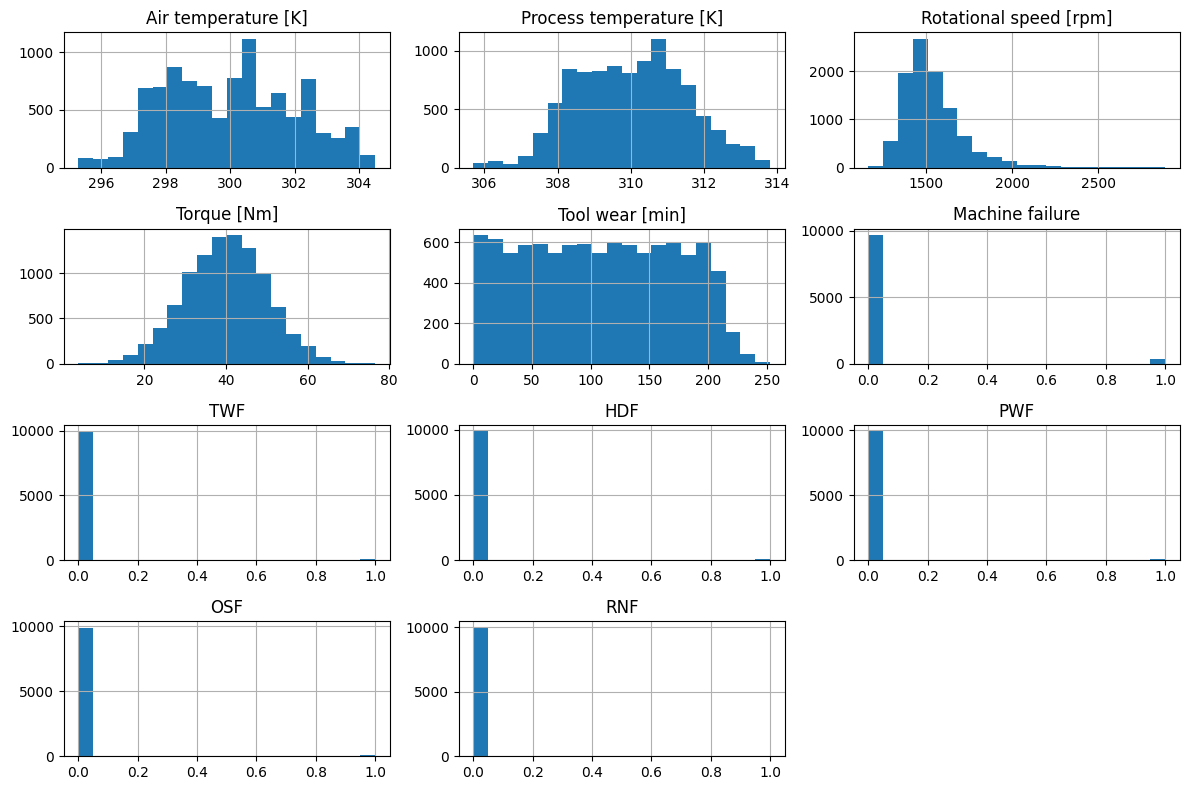

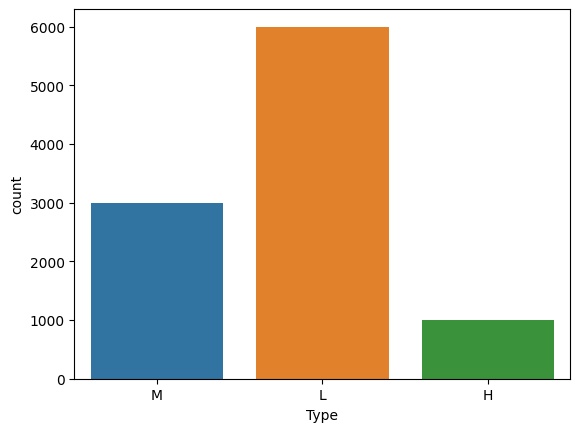

In [6]:
# 1. Univariate visualization for predictors (features)

# 1.1. numberical fields (11)
numerical_columns = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']
df[numerical_columns].hist(bins=20, figsize=(12, 8))
plt.tight_layout()  # Adjusts subplot spacing automatically
plt.show()
# rpm is a little bit skewed

# 1.2. categorical fields (1)
sns.countplot(x='Type', data=df)
plt.show()



In [7]:
import warnings 

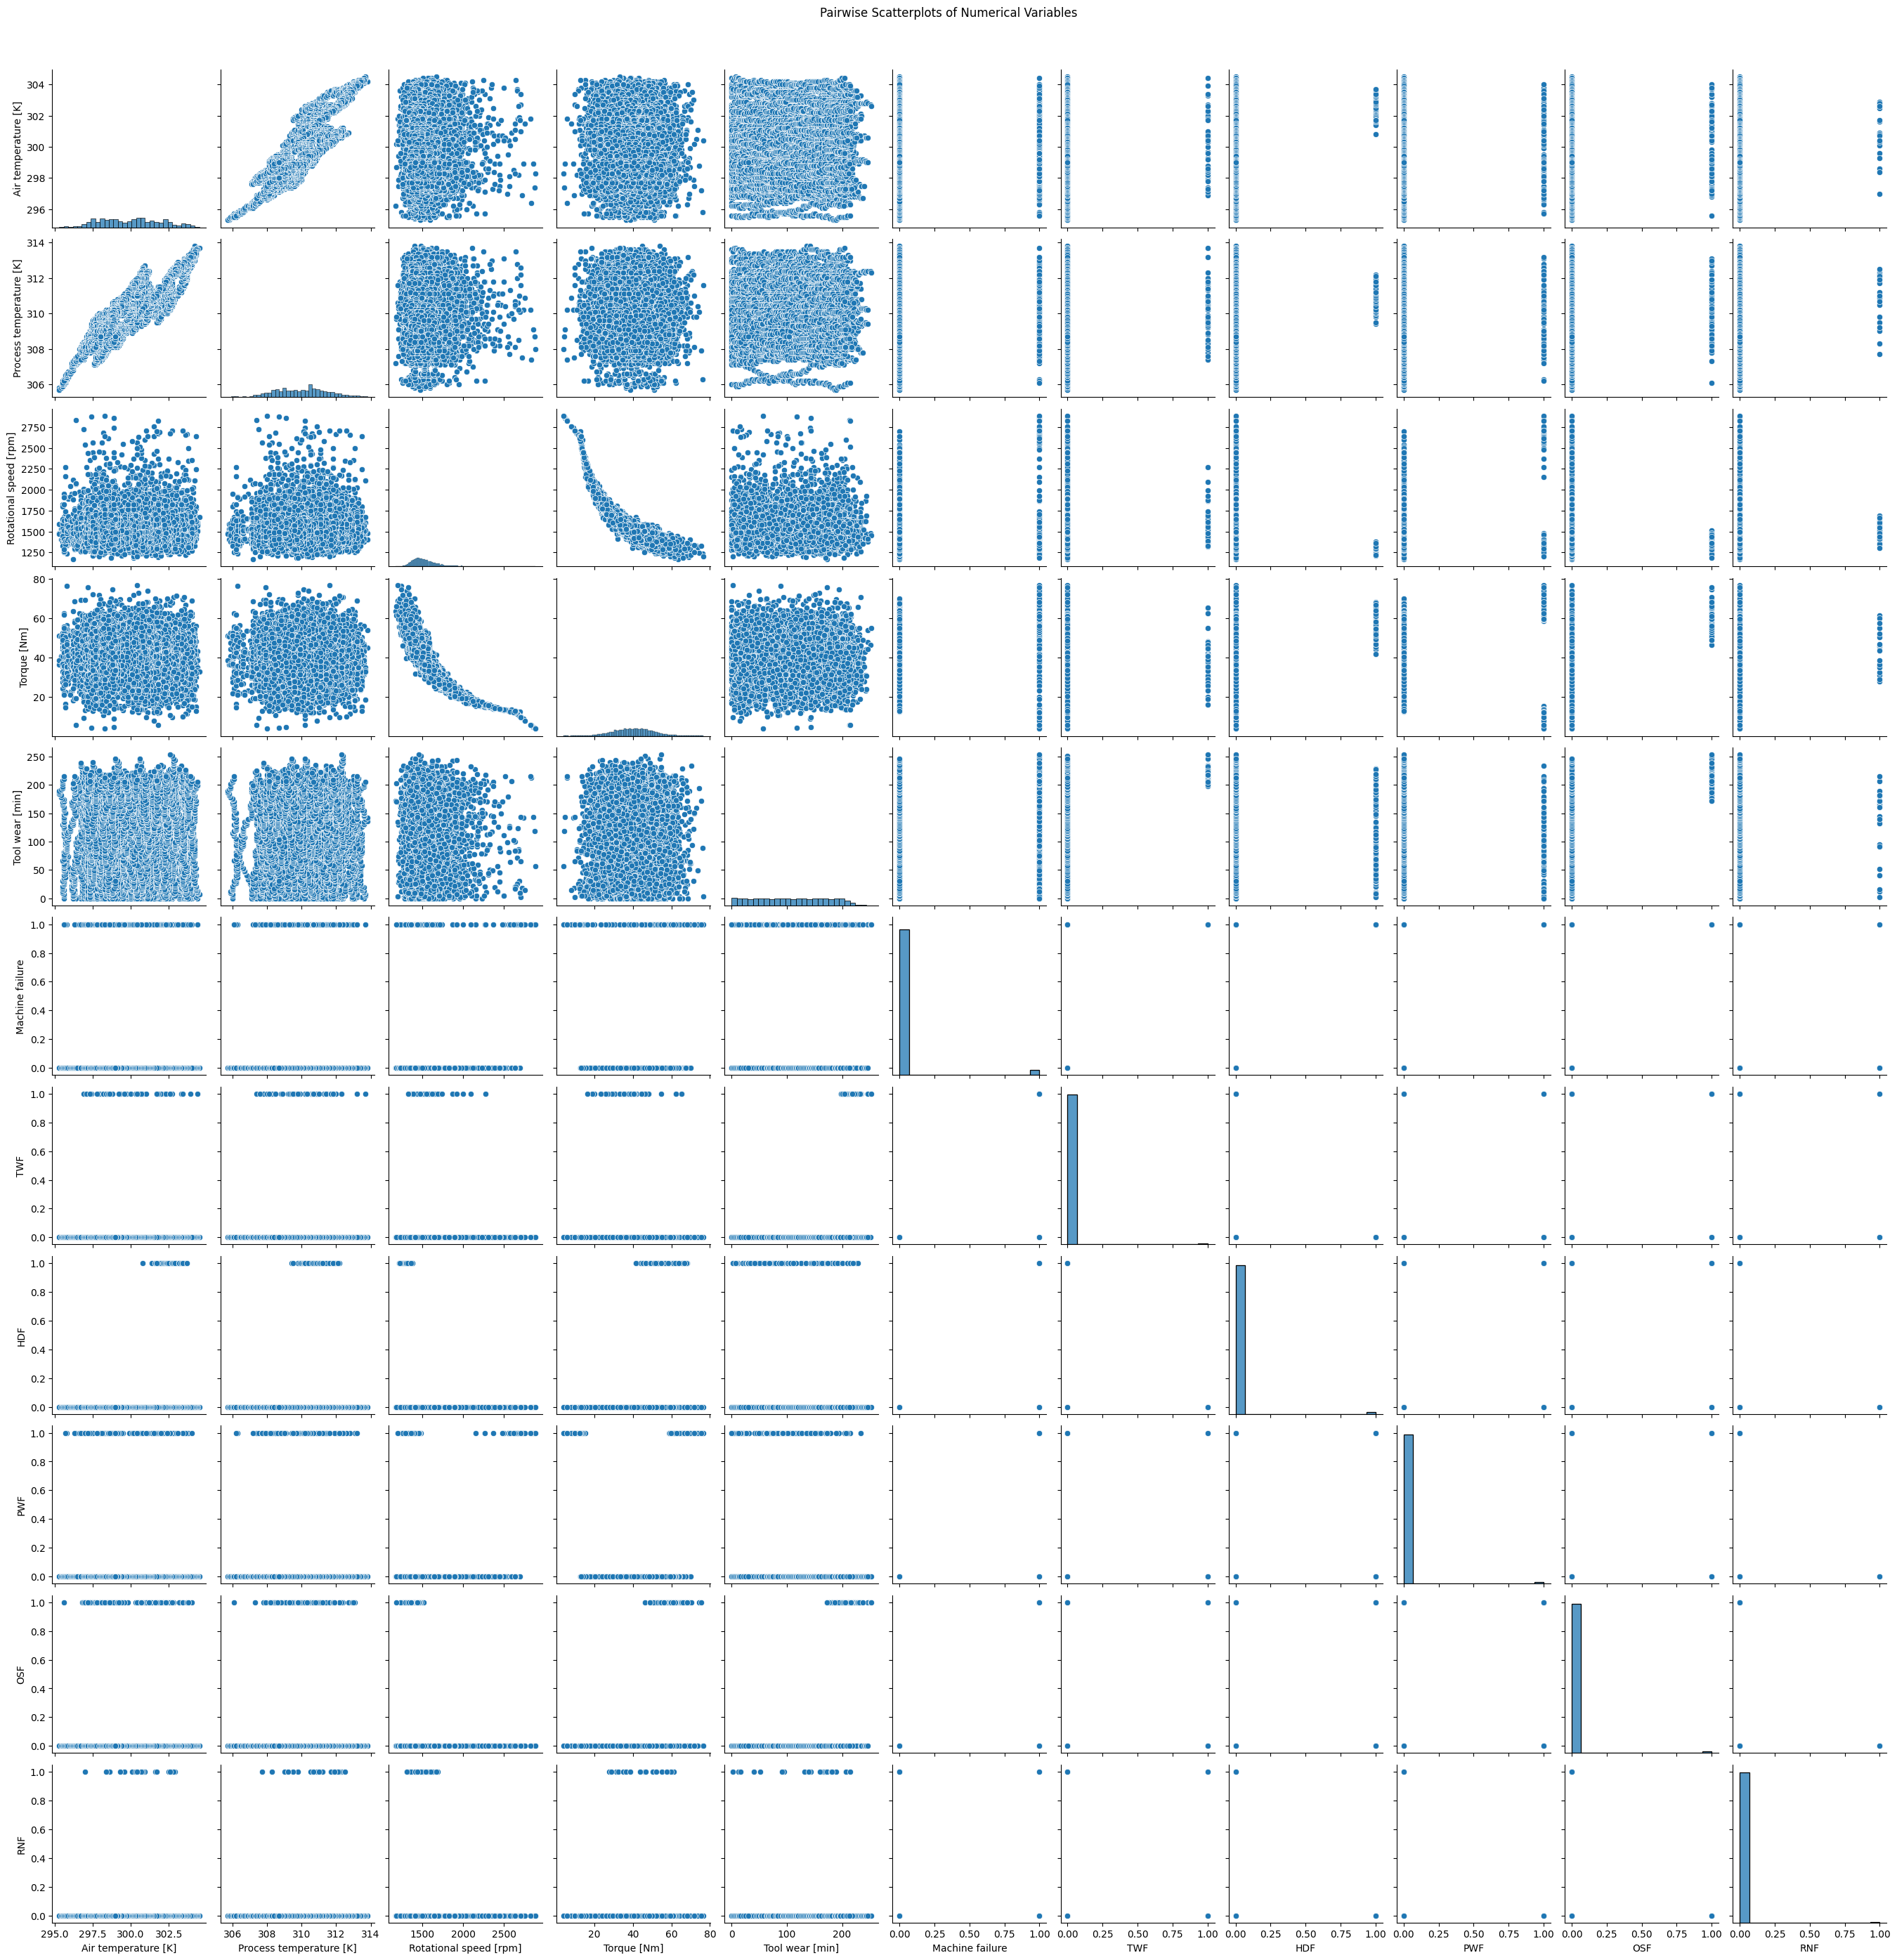

In [8]:
# 2. Univariate Visualization (scatterpots and heatmap)
# 2.1. scatterpolots
warnings.filterwarnings("ignore")
sns.pairplot(df[numerical_columns], palette='viridis')
plt.suptitle('Pairwise Scatterplots of Numerical Variables', y=1.02)
plt.show()

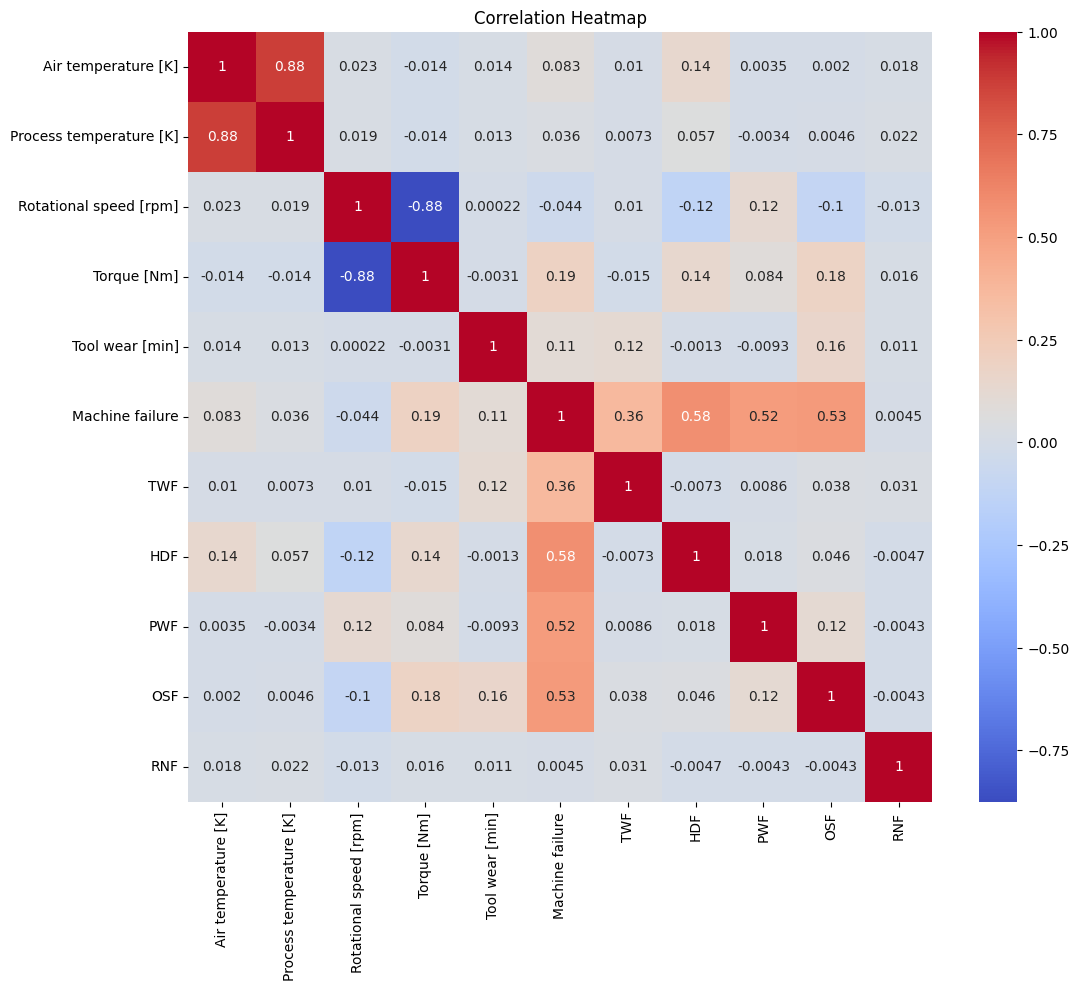

In [9]:
# 2.2. Correlation heatmap
plt.figure(figsize=(12, 10))
corr = df[numerical_columns].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

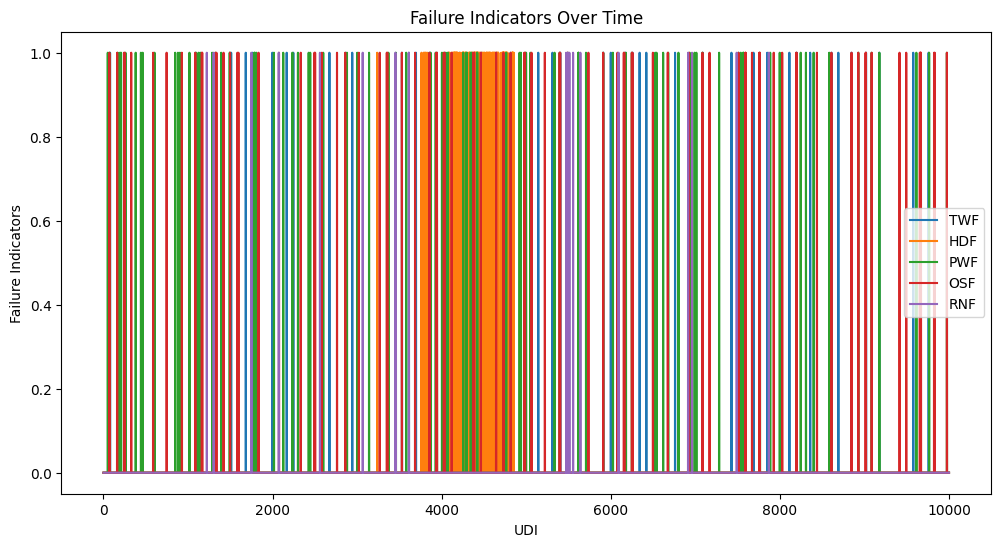

In [10]:
plt.figure(figsize=(12, 6))

# Plot all target variables
plt.plot(df['UDI'], df['TWF'], label='TWF')
plt.plot(df['UDI'], df['HDF'], label='HDF')
plt.plot(df['UDI'], df['PWF'], label='PWF')
plt.plot(df['UDI'], df['OSF'], label='OSF')
plt.plot(df['UDI'], df['RNF'], label='RNF')

# Labels and title
plt.xlabel('UDI')
plt.ylabel('Failure Indicators')
plt.title('Failure Indicators Over Time')
plt.legend()
plt.show()

In [18]:
# Define features (X) and multiple targets (y1, y2, y3, ... , y6)
X = df.drop(['Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF', 'Product ID'], axis=1)
X = pd.get_dummies(X, columns=['Type'])
y1 = df['Machine failure']  # Target 1
y2 = df['TWF']              # Target 2
y3 = df['HDF']              # Target 3
y4 = df['PWF']              # Target 4
y5 = df['OSF']              # Target 5
y6 = df['RNF']              # Target 6

# Split the dataset into training and testing sets (4:1)
# X_train, X_test, y1_train, y1_test, y2_train, y2_test, y3_train, y3_test, y4_train, y4_test, y5_train, y5_test, y6_train, y6_test = train_test_split(X, y1, y2, y3, y4, y5, y6, test_size=0.2)
X_train, X_test, y1_train, y1_test = train_test_split(X, y1, test_size=0.2, random_state=42)


In [12]:
profile


## Model Training

In [24]:
model = RandomForestClassifier()

# Train on y1 (Machine failure)
model.fit(X_train, y1_train)

# Predict on test data
y1_pred = model.predict(X_test)

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
 9   TWF                      10000 non-null  int64  
 10  HDF                      10000 non-null  int64  
 11  PWF                      10000 non-null  int64  
 12  OSF                      10000 non-null  int64  
 13  RNF                      10000 non-null  int64  
dtypes: float64(3), int64(9)

In [26]:
# Calculate metrics
print("Accuracy:", accuracy_score(y1_test, y1_pred))
print("\nClassification Report:\n", classification_report(y1_test, y1_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y1_test, y1_pred))

Accuracy: 0.985

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      1939
           1       0.84      0.62      0.72        61

    accuracy                           0.98      2000
   macro avg       0.92      0.81      0.85      2000
weighted avg       0.98      0.98      0.98      2000


Confusion Matrix:
 [[1932    7]
 [  23   38]]


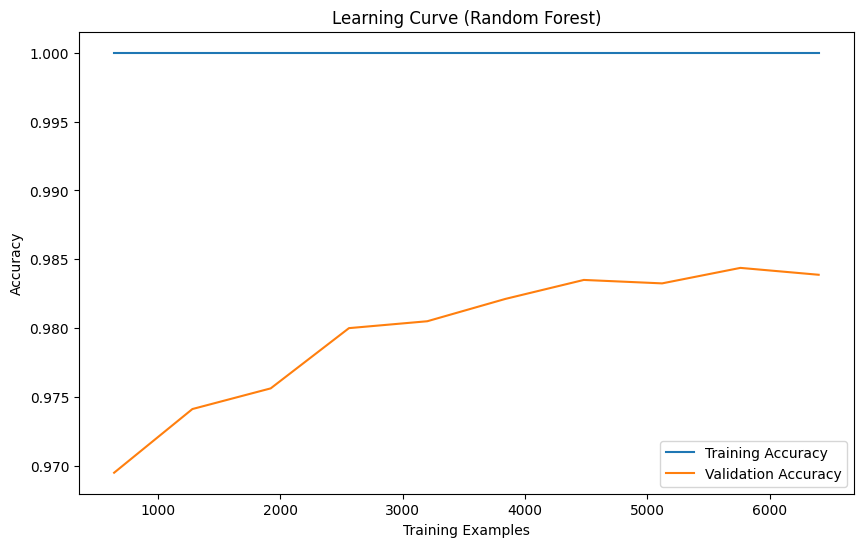

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

train_sizes, train_scores, val_scores = learning_curve(
    estimator=model,
    X=X_train,
    y=y1_train,
    cv=5,  # 5-fold cross-validation
    scoring='accuracy',
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10)
)

# Plot learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training Accuracy')
plt.plot(train_sizes, np.mean(val_scores, axis=1), label='Validation Accuracy')
plt.xlabel('Training Examples')
plt.ylabel('Accuracy')
plt.title('Learning Curve (Random Forest)')
plt.legend()
plt.show()